In [1]:
import numpy as np
import pickle
import h5py
import matplotlib.pyplot as plt
from evaluation import get_metric
from implicit.als import AlternatingLeastSquares
from scipy.sparse import csr_matrix
from sklearn.metrics import f1_score, accuracy_score
from sklearn.metrics import pairwise_distances

In [2]:
ingred_topk = 10

In [3]:
h5f_train = h5py.File('./Container/train', 'r')
train_features = h5f_train['features_boolean'][:]
train_labels = h5f_train['labels_one_hot'][:]
h5f_train.close()

In [4]:
h5f_valid = h5py.File('./Container/valid_cpl', 'r')
valid_features = h5f_valid['features_boolean'][:]
answer = h5f_valid['labels_id'][:].astype(np.int64)
h5f_valid.close()

answer_dict = {}
for i, ans in enumerate(answer):
    answer_dict[i] = ans

In [5]:
features_csr = csr_matrix(train_features)
features_csr_T = csr_matrix(features_csr.T)

In [6]:
macro_f1_lst = []
micro_f1_lst = []
acc_lst = []
MAP_lst = []
recall10_lst = []
recall_rank_lst = []

max_dim = 10

for i in range(max_dim):
    model = AlternatingLeastSquares(factors=2**(i+1), regularization=0.01, calculate_training_loss=True)
    model.fit(features_csr)
    
    sim_matrix = 1 - pairwise_distances(model.item_factors, metric="cosine") - np.eye(len(model.item_factors))
    score_matrix = valid_features @ sim_matrix
    rec_indices = np.argpartition(score_matrix, -ingred_topk)[:,-ingred_topk:]
    
    ingred_recs = {}
    for query, ingred_rec_idx in enumerate(rec_indices):
        ingred_recs[query] = []
        for idx in ingred_rec_idx:
            # ingred index를 1부터 시작하도록 함.
            ingred_recs[query].append((idx + 1, score_matrix[query, idx]))
        ingred_recs[query].sort(key=lambda x : x[1], reverse=True)
        
    with open("./recs/CF_rec_cpl_dim_{}.pickle".format(2**i), 'wb') as f:
        pickle.dump(ingred_recs, f)
        
    metric_dict = get_metric(ingred_recs, answer_dict)
    macro_f1_lst.append(metric_dict['macro'])
    micro_f1_lst.append(metric_dict['micro'])
    acc_lst.append(metric_dict['accuracy'])
    MAP_lst.append(metric_dict['map'])
    recall10_lst.append(metric_dict['recall'])
    recall_rank_lst.append(metric_dict['recall_rank'])

C:\Users\kami.DESKTOP-5P4EH18\anaconda3\envs\pytorch\lib\site-packages\implicit\utils.py:31: UserWarning: Intel MKL BLAS detected. Its highly recommend to set the environment variable 'export MKL_NUM_THREADS=1' to disable its internal multithreading
  warnings.warn(


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

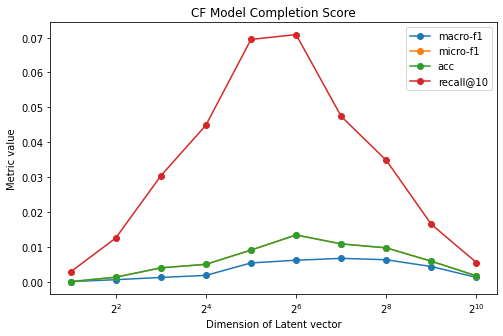

In [16]:
dim_lst = [2**(i+1) for i in range(max_dim)]

plt.figure(figsize=(8,5))
plt.plot(dim_lst, macro_f1_lst, 'o-', label='macro-f1')
plt.plot(dim_lst, micro_f1_lst, 'o-', label='micro-f1')
plt.plot(dim_lst, acc_lst, 'o-', label='acc')
# plt.plot(dim_lst, MAP_lst, 'o-', label='MAP')
plt.plot(dim_lst, recall10_lst, 'o-', label='recall@10')
plt.title("CF Model Completion Score")
plt.xscale('log', base=2)
plt.xlabel('Dimension of Latent vector')
plt.ylabel('Metric value')
plt.legend()
plt.savefig('./data_analysis/CF_cpl_scores.png', dpi=100)
plt.show()

In [ ]:
dim_lst = [2**(i+1) for i in range(max_dim)]

plt.figure(figsize=(8,5))
plt.plot(dim_lst, recall_rank_lst, 'o-', label='avg. recall rank')
plt.title("CF Model Classification Recall Rank")
plt.xscale('log', base=2)
plt.xlabel('Dimension of Latent vector')
plt.ylabel('recall rank')
plt.legend()
plt.savefig('./data_analysis/CF_cpl_recall_rank.png', dpi=100)
plt.show()

In [5]:
macro_f1_lst = []
micro_f1_lst = []
acc_lst = []
MAP_lst = []
recall10_lst = []
recall_rank_lst = []

max_dim = 10

for i in range(max_dim):
    with open("./recs/CF_rec_cpl_dim_{}.pickle".format(2**i), 'rb') as f:
        ingred_recs = pickle.load(f)
    
    metric_dict = get_metric(ingred_recs, answer_dict)
    macro_f1_lst.append(metric_dict['macro'])
    micro_f1_lst.append(metric_dict['micro'])
    acc_lst.append(metric_dict['accuracy'])
    MAP_lst.append(metric_dict['map'])
    recall10_lst.append(metric_dict['recall'])
    recall_rank_lst.append(metric_dict['recall_rank'])

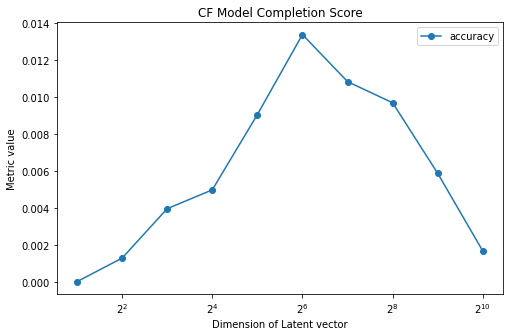

In [6]:
dim_lst = [2**(i+1) for i in range(max_dim)]

plt.figure(figsize=(8,5))
plt.plot(dim_lst, acc_lst, 'o-', label='accuracy')
#plt.plot(dim_lst, micro_f1_lst, 'o-', label='micro-f1')
plt.title("CF Model Completion Score")
plt.xscale('log', base=2)
plt.xlabel('Dimension of Latent vector')
plt.ylabel('Metric value')
plt.legend()
plt.savefig('./data_analysis/CF_cpl_scores.png', dpi=100)
plt.show()

In [15]:
max(macro_f1_lst)

0.006679629123930811

In [16]:
max(micro_f1_lst)

0.013379204892966361

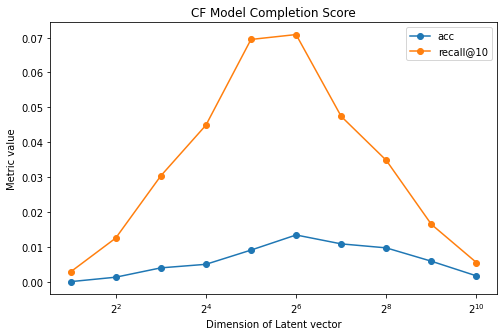

In [7]:
dim_lst = [2**(i+1) for i in range(max_dim)]

plt.figure(figsize=(8,5))
plt.plot(dim_lst, acc_lst, 'o-', label='acc')
# plt.plot(dim_lst, MAP_lst, 'o-', label='MAP')
plt.plot(dim_lst, recall10_lst, 'o-', label='recall@10')
plt.title("CF Model Completion Score")
plt.xscale('log', base=2)
plt.xlabel('Dimension of Latent vector')
plt.ylabel('Metric value')
plt.legend()
plt.savefig('./data_analysis/CF_cpl_entire_scores.png', dpi=100)
plt.show()

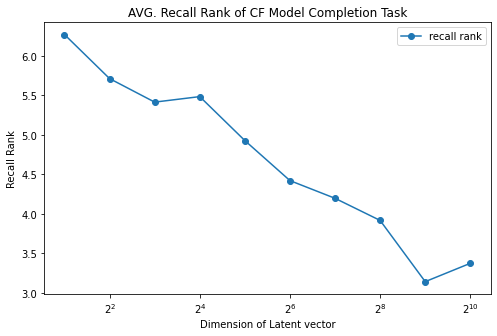

In [8]:
dim_lst = [2**(i+1) for i in range(max_dim)]

plt.figure(figsize=(8,5))
plt.plot(dim_lst, recall_rank_lst, 'o-', label='recall rank')
plt.title("AVG. Recall Rank of CF Model Completion Task")
plt.xscale('log', base=2)
plt.xlabel('Dimension of Latent vector')
plt.ylabel('Recall Rank')
plt.legend()
plt.savefig('./data_analysis/CF_cpl_recall_rank.png', dpi=100)
plt.show()